In [22]:
import os

import numpy as np
import pandas as pd

from tensorflow.keras.layers import Input, Dense, concatenate, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model

## Simple architecture with 2 outputs

In [2]:
inputs = Input(shape=(3,))

hidden1 = Dense(128, activation="relu")(inputs)
hidden2 = Dense(64, activation="relu")(hidden1)

output1 = Dense(1, activation="linear")(hidden2)
output2 = Dense(1, activation="sigmoid")(hidden2)

In [3]:
model = Model(inputs = inputs, outputs = [output1, output2])

In [4]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 3)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 128)          512         ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 64)           8256        ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 1)            65          ['dense_1[0][0]']                
                                                                                              

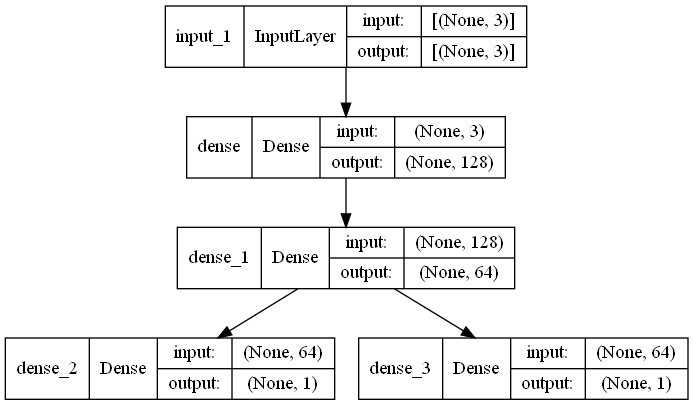

In [7]:
# So, 2 outputs
plot_model(model, show_shapes=True)

## More complex architecture with 2 inputs & 1 output

In [10]:
# define two sets of inputs
inputA = Input(shape=(32,))
inputB = Input(shape=(128,))

# the first branch operates on the first input
hiddenA1 = Dense(8, activation="relu")(inputA)
hiddenA2 = Dense(4, activation="relu")(hiddenA1)

# the second branch operates on the second input
hiddenB1 = Dense(64, activation="relu")(inputB)
hiddenB2 = Dense(32, activation="relu")(hiddenB1)
hiddenB3 = Dense(4, activation="relu")(hiddenB2)

# combine the both branches and make 1 output
combined = concatenate([hiddenA2, hiddenB3])

# apply a FC layer and then a regression prediction on the combined outputs
hidden1 = Dense(2, activation="relu")(combined)
output1 = Dense(1, activation="linear")(hidden1)

# now accept the input and output layers
model = Model(inputs=[inputA, inputB], outputs=output1)

In [11]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 dense_13 (Dense)               (None, 64)           8256        ['input_5[0][0]']                
                                                                                                  
 dense_11 (Dense)               (None, 8)            264         ['input_4[0][0]']                
                                                                                            

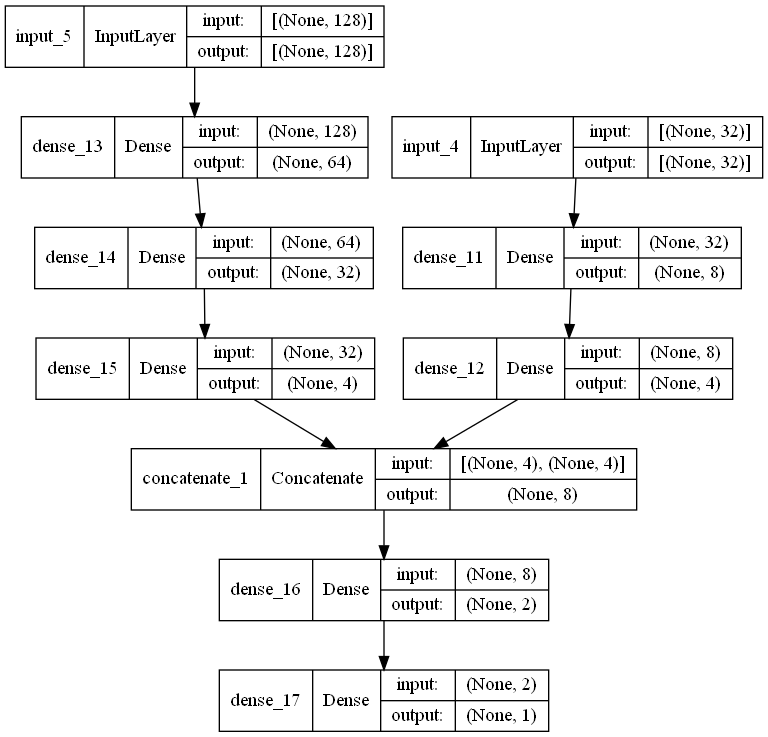

In [12]:
plot_model(model, show_shapes=True)

## Now a proper example (predict person's age & gender) with VGG16

In [14]:
age = []
gender = []
img_path = []

folder_path = os.path.join("data", "UTKFace", "utkface_aligned_cropped", "UTKFace")
for file in os.listdir(folder_path):
    info = file.split("_")
    age.append(int(info[0]))
    gender.append(int(info[1]))
    img_path.append(file)
    
print(len(age), len(gender), len(img_path))

23708 23708 23708


In [16]:
df = pd.DataFrame({"age": age, "gender": gender, "img": img_path})
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (23708, 3)


,age,gender,img
0,100,0,100_0_0_20170112213500903.jpg.chip.jpg
1,100,0,100_0_0_20170112215240346.jpg.chip.jpg
2,100,1,100_1_0_20170110183726390.jpg.chip.jpg
3,100,1,100_1_0_20170112213001988.jpg.chip.jpg
4,100,1,100_1_0_20170112213303693.jpg.chip.jpg


In [17]:
train_df = df.sample(frac=1, random_state=0).iloc[:20000]
test_df  = df.sample(frac=1, random_state=0).iloc[20000:]

train_df.shape, test_df.shape

((20000, 3), (3708, 3))

In [19]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [20]:
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=folder_path,
    y_col=["age", "gender"],
    x_col="img",
    target_size=(200, 200),
    class_mode="multi_output"
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    directory=folder_path,
    x_col="img",
    y_col=["age", "gender"],
    target_size=(200, 200),
    class_mode="multi_output"
)

Found 20000 validated image filenames.
Found 3708 validated image filenames.


In [23]:
vggnet = VGG16(include_top=False, input_shape=(200, 200, 3))
vggnet.trainable = False

output = vggnet.layers[-1].output

flatten = Flatten()(output)

dense1 = Dense(512, activation="relu")(flatten)
dense2 = Dense(512, activation="relu")(flatten)

dense3 = Dense(512, activation="relu")(dense1)
dense4 = Dense(512, activation="relu")(dense2)

output1 = Dense(1, activation="linear", name="age")(dense3)
output2 = Dense(1, activation="sigmoid", name="gender")(dense4)

model = Model(inputs=vggnet.input, outputs=[output1, output2])

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 200, 200, 64  1792        ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 200, 200, 64  36928       ['block1_conv1[0][0]']           
                                )                                                           

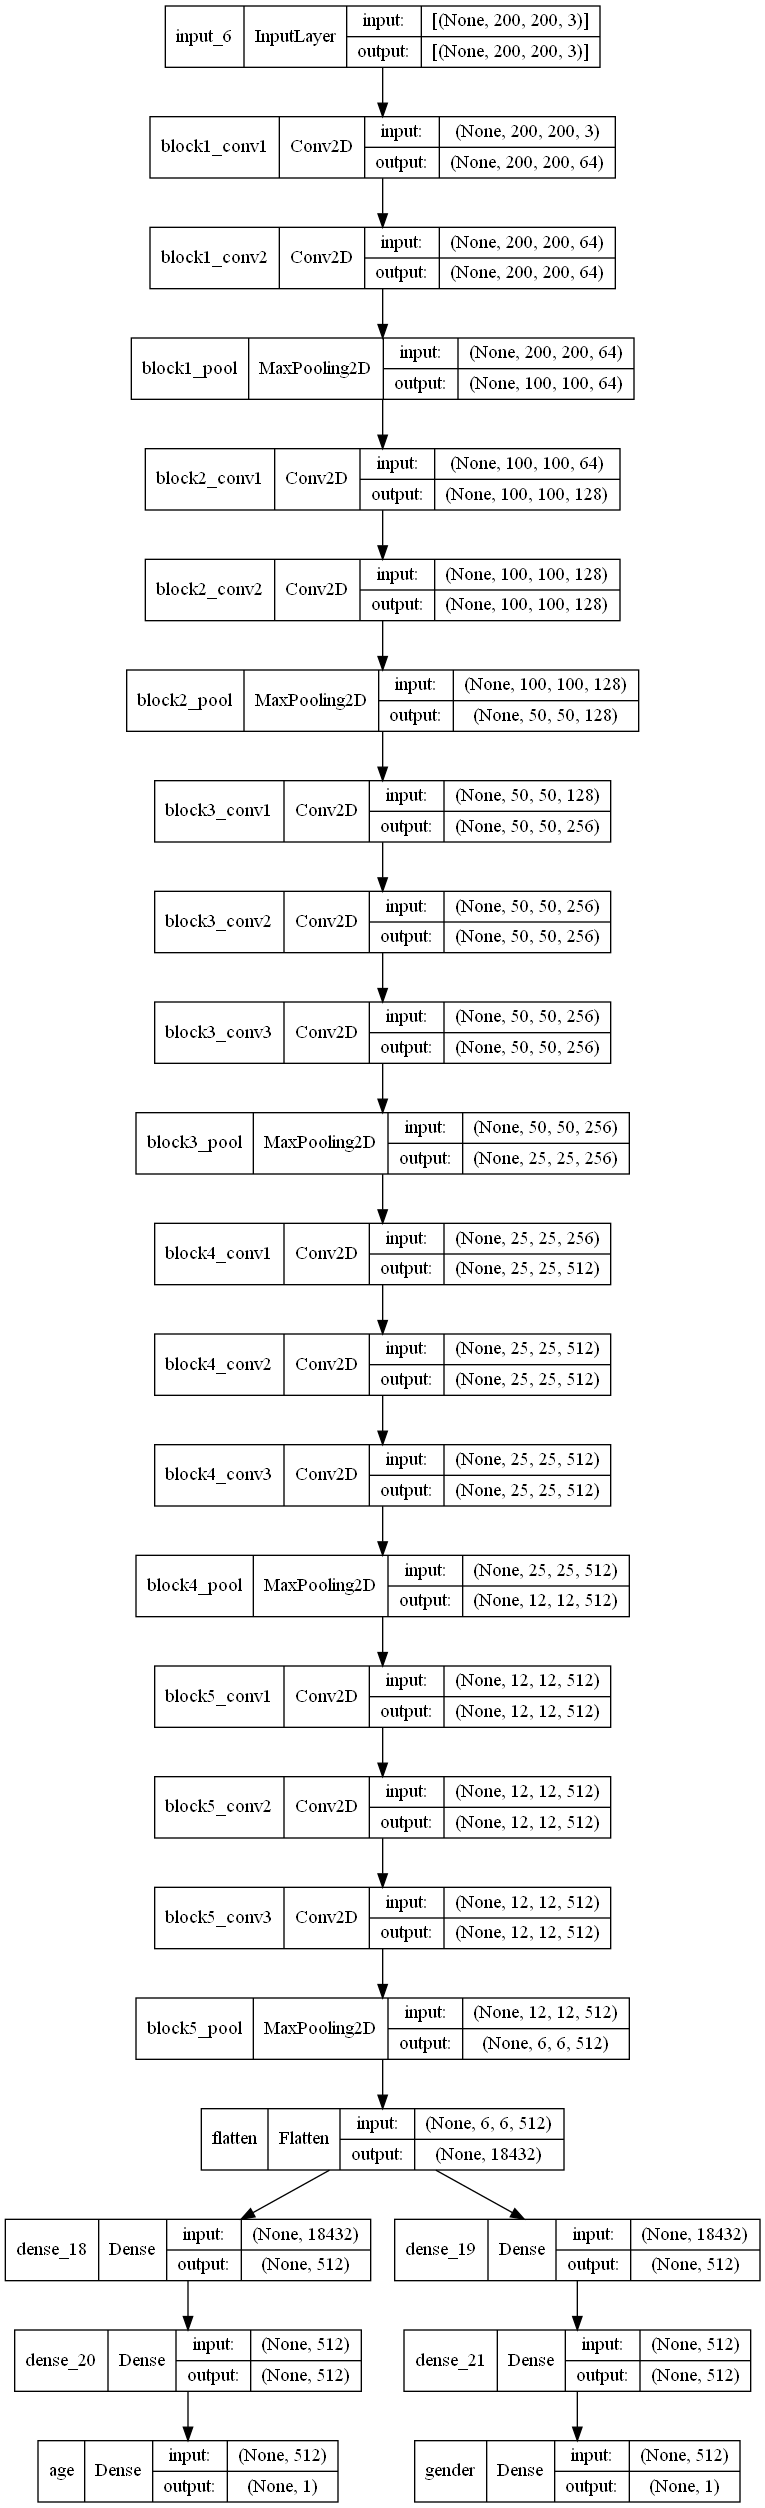

In [24]:
plot_model(model, show_shapes=True)

In [ ]:
%%time

model.compile(
    optimizer="adam",
    loss={"age":"mae", "gender": "binary_crossentropy"},
    metrics={"age": "mae", "gender": "accuracy"},
    loss_weights={"age": 1, "gender": 99}
)

model.fit(train_generator, batch_size=32, epochs=10, validation_data=test_generator)